In [1]:
import os
import sys
parent_dir_abs = os.path.abspath(os.pardir)
sys.path.insert(0, parent_dir_abs) 

import torch
import torch.nn as nn
import numpy as np

import pyro
from pyro import poutine
from pyro import distributions as dist
from pyro_oed_src import nmc_eig, _safe_mean_terms, _create_condition_input
from pyro.contrib.util import lexpand, rexpand

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f'Using device: {device}.')

#set default dtype
torch.set_default_dtype(torch.float32)

Using device: cuda:0.


In [3]:
np_dtype = np.float64
redshifts = np.arange(0.2, 4, 0.2, dtype=np_dtype)
designs = torch.tensor(redshifts).to(device).unsqueeze(-1)
designs[0:5]

tensor([[0.2000],
        [0.4000],
        [0.6000],
        [0.8000],
        [1.0000]], device='cuda:0', dtype=torch.float64)

In [4]:
def model_func(om, z):
    return 30.21/torch.sqrt(om*(1+z)**3+(1-om))

In [6]:
class likelihood_dist(dist.Distribution):
    def __init__(self, om, z, y_1, y_2, sig_0, sig_1, sig_2):
        self.om = om
        self.z = z
        self.y_1 = y_1
        self.y_2 = y_2
        self.sig_0 = sig_0
        self.sig_1 = sig_1
        self.sig_2 = sig_2
        super().__init__()

    def sample(self, sample_shape=torch.Size([])):
        """
        Generate random samples from the distribution.

        Args:
            sample_shape (torch.Size): The shape of the samples to generate.
        Returns:
            torch.Tensor: Random samples from the distribution.
        """
        # sample from a gaussian centered on model prediction with std sigma
        samples = dist.Normal(model_func(self.om, self.z[...,0]), self.sig_0).sample(sample_shape)
        return samples

    def log_prob(self, value):
        """
        Compute the log probability density (log PDF) of the distribution at a given value.

        Args:
            value (torch.Tensor): The value(s) at which to compute the log PDF.
        Returns:
            torch.Tensor: The log PDF of the distribution at the given value(s).
        """
        prob_y_0 = dist.Normal(model_func(self.om, self.z[...,0]), self.sig_0).log_prob(value)
        prob_y_1 = dist.Normal(model_func(self.om, self.z[...,1]), self.sig_1).log_prob(self.y_1)
        prob_y_2 = dist.Normal(model_func(self.om, self.z[...,2]), self.sig_2).log_prob(self.y_2)
        log_prob = prob_y_0+prob_y_1+prob_y_2
        return log_prob

In [6]:
om_prior = torch.tensor(0.315, device=device) # Gaussian prior mean
sigma_prior = torch.tensor(0.02, device=device) # Gaussian prior std
sig_0 = torch.tensor(0.2, device=device) # Gaussian likelihood std
y_1 = torch.tensor(19.770, device=device) # LRG measurements mean
sig_1 = torch.tensor(0.47, device=device) # LRG measurements std
y_2 = torch.tensor(8.99, device=device) # Lyman-alpha measurements mean
sig_2 = torch.tensor(0.19, device=device) # Lyman-alpha measurements std

def model(z):
    with pyro.plate_stack("plate", z.shape[:-1]):
        om = pyro.sample("om", dist.Normal(om_prior,sigma_prior)) # shape: [n,num_designs,1]
        y = model_func(om, z)
        return pyro.sample("y", dist.Normal(y.squeeze(), sig_0))

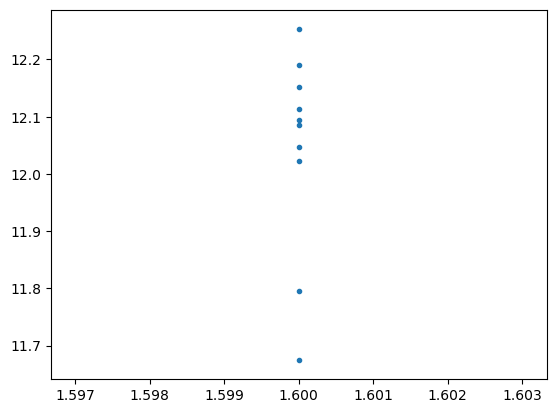

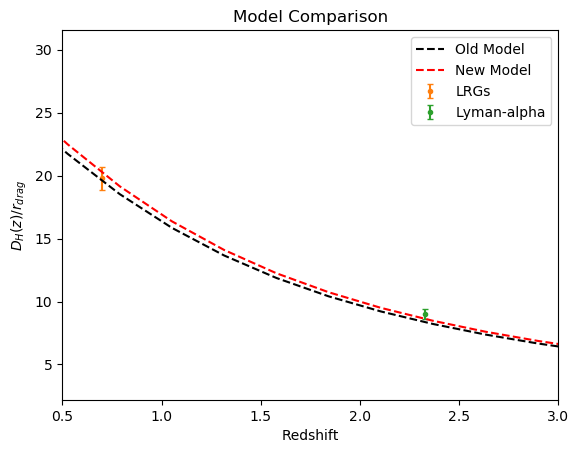

In [7]:
num_samples = 10
om = 0.315
redshift_idx = 7
z = np.linspace(0,5,20)
conditioned_model = pyro.condition(model, data={"om": torch.tensor(om, device=device)})
samples = conditioned_model(lexpand(designs[redshift_idx], num_samples))

plt.figure()
plt.scatter(lexpand(designs[redshift_idx], 
            num_samples).cpu().numpy(), 
            samples.cpu().numpy(), 
            marker='.', 
            label="Measure at z={:.2f}, $\sigma={:.1f}$".format(redshifts[redshift_idx], 
            sig_0.cpu().numpy()))
plt.figure()
# plot point with error bars using default matplotlib colors
plt.errorbar(0.698, y_1.cpu().numpy(), yerr=2*sig_1.cpu().numpy(), label='LRGs', barsabove=True, capsize=2, fmt='.', color='#ff7f0e')
plt.errorbar(2.33, y_2.cpu().numpy(), yerr=2*sig_2.cpu().numpy(), label='Lyman-alpha', barsabove=True, capsize=2, fmt='.', color='#2ca02c')
plt.plot(z, 29.09/np.sqrt(0.31*(1+z)**3+(1-0.31)), label='Old Model', color="black", linestyle="--")
plt.plot(z, 30.21/np.sqrt(0.315*(1+z)**3+(1-0.315)), label='New Model', color="red", linestyle="--")
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('$D_H(z)/r_{drag}$')
plt.xlim(0.5, 3)
plt.title("Model Comparison")
plt.show()

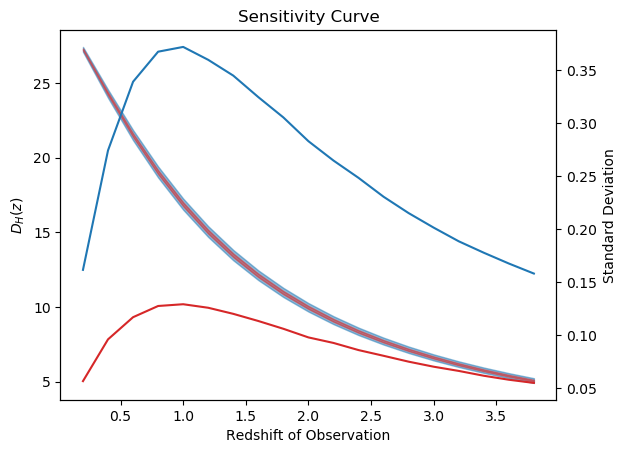

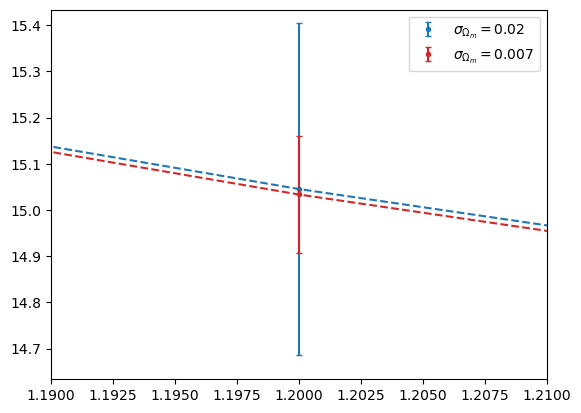

In [20]:
fig, ax1 = plt.subplots()
fig3, ax3 = plt.subplots()
ax2 = ax1.twinx()
colors = ["tab:blue", "tab:red"]
for i in [0.02, 0.007]:
    next_color = colors.pop(0)
    om_prior = torch.tensor(0.315, device=device) # Gaussian prior mean
    sigma_prior = torch.tensor(i, device=device) # Gaussian prior std
    def om_samples(designs):
        with pyro.plate_stack("plate", designs.shape[:-1]):
            om = pyro.sample("om", dist.Normal(om_prior,sigma_prior))
            y = 30.21*((om*(1+designs.squeeze())**3+(1-om))**(-1/2))
            return y
    # i want to plot a sensitivity curve of y given different values of om
    samples = 50000
    data = om_samples(lexpand(designs, samples)).squeeze().cpu()
    sd = np.sqrt(data.var(axis=0).numpy())


    # plot mean and confidence interval on primary y-axis
    #ax1.plot(designs.squeeze().cpu().numpy(), data.mean(axis=0).numpy(), linestyle='--', color=next_color)
    ax1.fill_between(designs.squeeze().cpu().numpy(), data.mean(axis=0).numpy()-sd, data.mean(axis=0).numpy()+sd, alpha=0.5, color=next_color, label=r"$\sigma_{\Omega_m}=$"+f"{i}")

    # plot standard deviation on secondary y-axis
    # how can i plot two different datasets with a fixed y-axis on the secondary axis?
    ax2.plot(designs.squeeze().cpu().numpy(), sd, color=next_color)

    ax3.plot(designs.squeeze().cpu().numpy(), data.mean(axis=0).numpy(), linestyle='--', color=next_color)
    ax3.errorbar(designs.squeeze().cpu().numpy()[5], data.mean(axis=0).numpy()[5], yerr=sd[5], label=r"$\sigma_{\Omega_m}=$"+f"{i}", barsabove=True, capsize=2, fmt='.', color=next_color)


ax1.set_xlabel("Redshift of Observation")
ax1.set_ylabel("$D_H(z)$")
ax1.set_title("Sensitivity Curve")
ax2.set_ylabel("Standard Deviation")
ax2.tick_params(axis='y')

ax3.set_xlim(designs.squeeze().cpu().numpy()[5]-0.01, designs.squeeze().cpu().numpy()[5]+0.01)
ax3.set_ylim(data.mean(axis=0).numpy()[5]-0.4, data.mean(axis=0).numpy()[5]+0.4)
ax3.legend()

plt.show()